## General imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.1)


# Data pre-processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

# modelling specifics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Common functions

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, data_type):

    print(f"{data_type} PERFORMANCE:")
    print("----------------------")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R-squared: {r2_score(y_true, y_pred)}\n")
    
# Create an empty dictionary to hold the metrics
metrics_dict = {
    "original features untuned": {"rmse": np.nan, "r2": np.nan},
    "original features tuned": {"rmse": np.nan, "r2": np.nan},
    "all new features": {"rmse": np.nan, "r2": np.nan},
    "Features above > 0.01": {"rmse": np.nan, "r2": np.nan},
    "Features above > 0.02": {"rmse": np.nan, "r2": np.nan},
}

def save_metrics(y_true, y_pred, model_description):
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Update the global dictionary
    global metrics_dict
    metrics_dict[model_description]["rmse"] = rmse
    metrics_dict[model_description]["r2"] = r2

## Read and view the data

In [3]:
df = pd.read_csv("FSOData.csv")

df.head(3)

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Time,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP Code
0,7.913289,17.595709,3.057066,65884.51846,9,6.863808,26.067846,13.63,0.0,2115.338398,0
1,7.451176,17.549693,2.727910,64963.41092,9,6.468903,25.645703,-0.54,0.0,2113.999257,0
2,7.072747,17.290230,1.674810,54794.28107,10,2.826916,25.653383,-0.24,0.0,2118.689047,0


## Exploratory data analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FSO_Att                 91379 non-null  float64
 1   Absolute Humidity       91379 non-null  float64
 2   Wind Speed              91379 non-null  float64
 3   Visibility              91379 non-null  float64
 4   Time                    91379 non-null  int64  
 5   Wind Speed Max          91379 non-null  float64
 6   Temperature             91379 non-null  float64
 7   Temperature Difference  91379 non-null  float64
 8   Particulate             91379 non-null  float64
 9   Distance                91379 non-null  float64
 10  SYNOP Code              91379 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 7.7 MB


In [5]:
df.describe()

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Time,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP Code
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,9.553919,0.739065,32986.417484,11.373193,1.851020,12.536912,-0.065506,27.065979,3297.930328,2.213101
std,3.903843,5.858577,0.871314,24713.874445,6.942229,1.762698,9.132673,0.798295,72.134023,1224.305893,2.879657
min,0.788363,1.141556,0.000000,10.151990,0.000000,0.000000,-6.894074,-11.157000,0.000000,2012.000148,0.000000
25%,3.473063,4.958993,0.076749,11158.598400,5.000000,0.512667,4.675576,-0.400000,0.000000,2019.431812,0.000000
50%,6.336167,6.870737,0.437995,26378.636210,11.000000,1.323101,10.276256,-0.100000,0.000000,2959.863686,0.000000
75%,8.664984,14.049470,1.088621,53493.821285,17.000000,2.681788,21.473233,0.250000,16.947618,4820.890157,6.000000
max,32.455222,24.790883,7.799086,75004.999150,23.000000,16.421115,37.257974,13.630000,1621.001906,4827.999971,8.000000


### Visual distribution using histograms

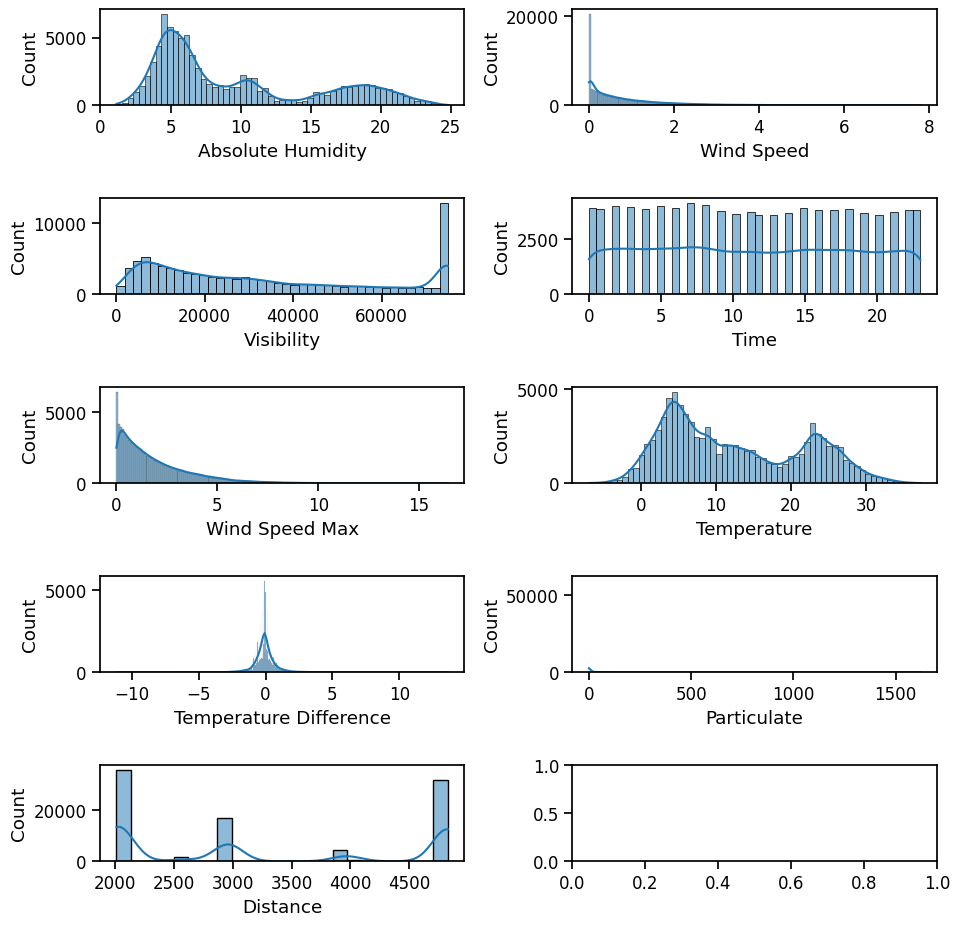

In [4]:
# Define the features to display histograms for
features = ['Absolute Humidity', 'Wind Speed', 'Visibility',
            'Time', 'Wind Speed Max', 'Temperature', 'Temperature Difference',
            'Particulate', 'Distance']

# Create a 5x2 grid of subplots for histograms
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout(pad=3.0)  # Adjust the spacing between subplots

# Iterate through the features and plot histograms in each subplot
for i, feature in enumerate(features):
    row = i // 2  # Row index
    col = i % 2   # Column index

    # Plot histogram in the corresponding subplot
    sns.histplot(data=df, x=feature, kde=True, ax=axes[row, col])

# Display the plot
plt.show()

### Data pre-proocessing

In [6]:
# Convert NaN values to a new category for categorical variables
df['SYNOP Code'] = df['SYNOP Code'].fillna('missing').astype(str)

# Define preprocessor
num_features = ['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time', 
                'Wind Speed Max', 'Temperature', 'Temperature Difference', 
                'Particulate', 'Distance']

cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(random_state=42))])


### Histogram of scaled features

In [ ]:
_X = df.drop('FSO_Att', axis=1)
_y = df['FSO_Att']
_clf = clf

# Fit the pipeline
_clf.fit(_X , _y)


# Get the transformed DataFrame
transformed_df = pd.DataFrame(_clf.named_steps['preprocessor'].transform(_X))

# Assign column names to the transformed DataFrame
transformed_df.columns = num_features + list(_clf.named_steps['preprocessor']
                                            .transformers_[1][1]['onehot'].get_feature_names_out(cat_features))



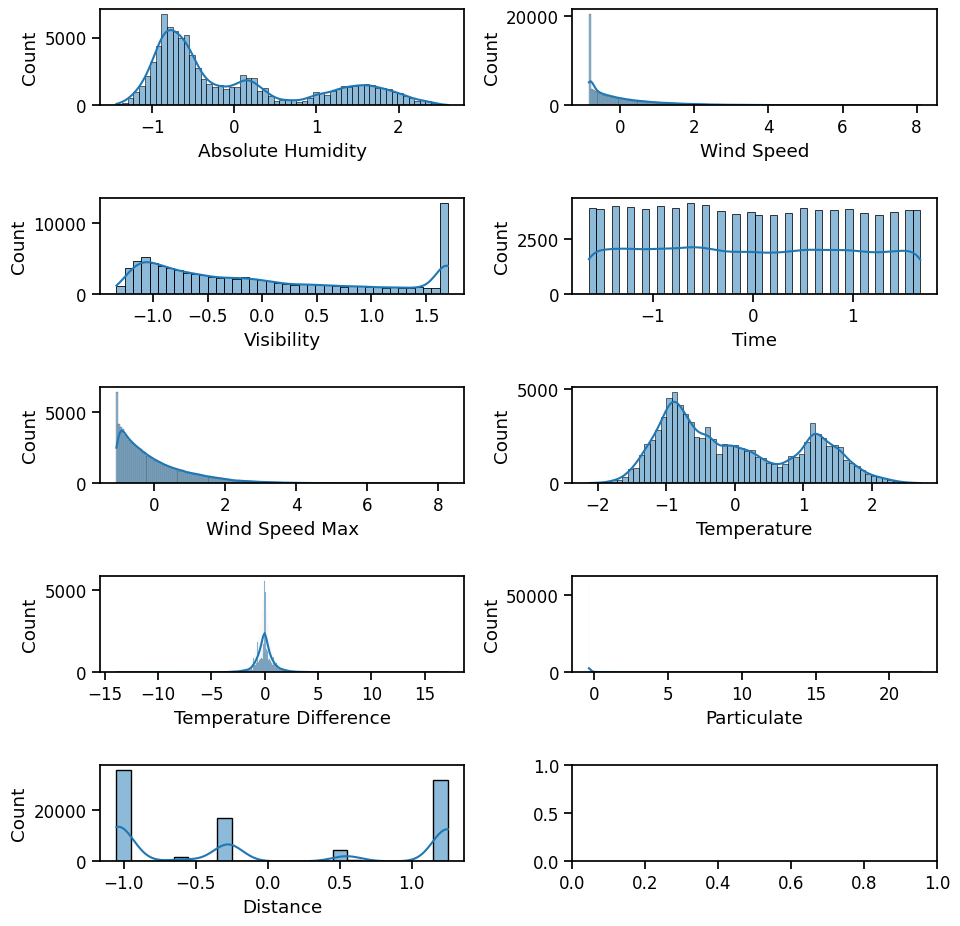

In [13]:

# Plot histograms of the scaled features
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout(pad=3.0)

for i, column in enumerate(transformed_df[num_features].columns):
    if column != 'SYNOP Code':
        row = i // 2
        col = i % 2
        sns.histplot(data=transformed_df, x=column, kde=True, ax=axes[row, col])
    else :
            pass

plt.show()

## Split the data set into training and testing

In [4]:
# Separate features and target variable
X = df.drop('FSO_Att', axis=1)
y = df['FSO_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Train and evaluate the model

In [ ]:
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)

y_pred = clf.predict(X_test)
# Calculate the evaluation metrics for the training data
print_metrics(y_train, train_predictions, 'TRAINING Original features untuned')
print_metrics(y_test, y_pred, 'TESTING Original features untuned')
save_metrics(y_test, y_pred, "original features untuned")

### Visualize the results

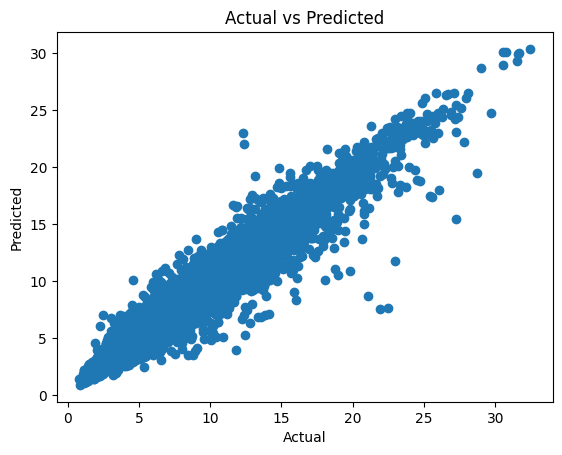

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### Paramater tuning 

In [ ]:
from sklearn.model_selection import train_test_split

# X is your feature set and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [200,250],
    'max_depth': [None, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Initialize a Random Forest estimator
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model
best_rf = grid_search.best_estimator_

# Training and Testing performance
train_predict = best_rf.predict(X_train)
test_predict = best_rf.predict(X_test)


print_metrics(y_train, train_predict, 'TRAINING original features tuned')
print_metrics(y_test, test_predict, 'TESTING original features tuned')
save_metrics(y_test, test_predict, "original features tuned")


In [19]:
print_metrics(y_train, train_predict, 'TRAINING')
print_metrics(y_test, test_predict, 'TESTING')

TRAINING PERFORMANCE:
----------------------
Root Mean Squared Error: 0.29566907318330626
R-squared: 0.9943068931052464

TESTING PERFORMANCE:
----------------------
Root Mean Squared Error: 0.7716744384847268
R-squared: 0.9602115693955574



In [38]:
best_params

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

### Feature importance

In [108]:
# Get feature importance
importances = clf['classifier'].feature_importances_

# Get the names of the columns from the dataframe
feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

NameError: name 'clf' is not defined

## With features removed

TRAINING PERFORMANCE:
----------------------
Mean Absolute Error: 0.1679960230281564
Mean Squared Error: 0.08964687842900532
Root Mean Squared Error: 0.2994108856220918
R-squared: 0.994161884132153
TESTING PERFORMANCE:
----------------------
Mean Absolute Error: 0.4441334770363946
Mean Squared Error: 0.6120236662983878
Root Mean Squared Error: 0.7823194144966542
R-squared: 0.9591062633031092


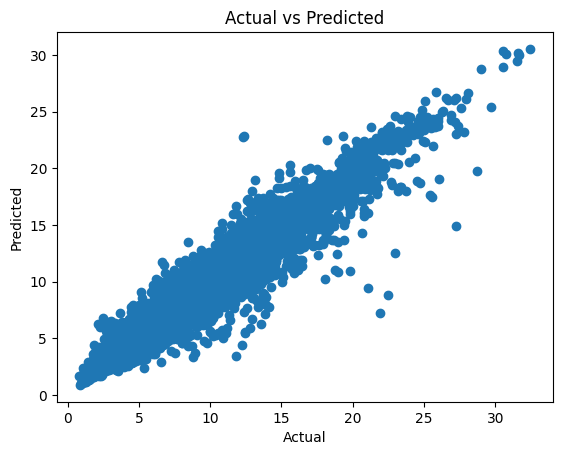

In [39]:
df_new = df.drop(columns=['Wind Speed', 'Wind Speed Max', 'SYNOP Code'])

# Define preprocessor
num_features = ['Absolute Humidity', 'Visibility', 'Time', 
                'Temperature', 'Temperature Difference', 
                'Particulate', 'Distance']

# cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# cat_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)])

# Append classifier to preprocessing pipeline
clf_2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators= 100, random_state=42))])
                      

# Separate features and target variable
X_i = df_new.drop('FSO_Att', axis=1)
y_i = df_new['FSO_Att']


X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size = 0.3, random_state = 42)

# model = RandomForestRegressor(n_estimators= 100, random_state=42)
clf_2.fit(X_train_i, y_train_i)

train_predictions_i = clf_2.predict(X_train_i)

# Calculate the evaluation metrics for the training data
train_mae = metrics.mean_absolute_error(y_train_i, train_predictions_i)
train_mse = metrics.mean_squared_error(y_train_i, train_predictions_i)
train_rmse = np.sqrt(train_mse)
train_r2 = metrics.r2_score(y_train_i, train_predictions_i)

# Print the evaluation metrics
print('TRAINING PERFORMANCE:')
print('----------------------')
print(f'Mean Absolute Error: {train_mae}')
print(f'Mean Squared Error: {train_mse}')
print(f'Root Mean Squared Error: {train_rmse}')
print(f'R-squared: {train_r2}')



y_pred_i = clf_2.predict(X_test_i)

# Calculate the evaluation metrics for the training data
test_mae = metrics.mean_absolute_error(y_test_i, y_pred_i)
test_mse = metrics.mean_squared_error(y_test_i, y_pred_i)
test_rmse = np.sqrt(test_mse)
test_r2 = metrics.r2_score(y_test_i, y_pred_i)

# Print the evaluation metrics
print('TESTING PERFORMANCE:')
print('----------------------')
print(f'Mean Absolute Error: {test_mae}')
print(f'Mean Squared Error: {test_mse}')
print(f'Root Mean Squared Error: {test_rmse}')
print(f'R-squared: {test_r2}')


plt.scatter(y_test_i, y_pred_i)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

## Tuning with few hyperparameters

In [40]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Initialize a Random Forest estimator
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_i, y_train_i)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model
best_rf = grid_search.best_estimator_

# Training and Testing performance
train_predict = best_rf.predict(X_train_i)
test_predict = best_rf.predict(X_test_i)

print_metrics(y_train_i, train_predict, 'TRAINING')
print_metrics(y_test_i, test_predict, 'TESTING')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  19.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  41.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  41.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  16.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_

### Feature engineering

In [ ]:
df_ii = df.copy()

df_ii['Time'] = pd.to_datetime(df_ii['Time'])

# df_ii.info()

# Create interaction features
df_ii['Temp_AbsHumid'] = df_ii['Temperature'] * df_ii['Absolute Humidity']
df_ii['Wind_Part'] = df_ii['Wind Speed'] * df_ii['Particulate']

# Create change rate features
df_ii['Temp_ChangeRate'] = df_ii['Temperature'].diff()
df_ii['Visib_ChangeRate'] = df_ii['Visibility'].diff()

# Create a feature representing the elapsed time since the first observation
df_ii['Elapsed_Time'] = (df_ii['Time'] - df_ii['Time'].iloc[0]).dt.total_seconds()

# Create a feature representing the difference in time from the previous observation
df_ii['Time_Diff'] = df_ii['Elapsed_Time'].diff()

# Change time column back to int
df_ii['Time'] = df_ii['Time'].astype(int)



# Convert NaN values to a new category for categorical variables
df_ii['SYNOP Code'] = df_ii['SYNOP Code'].fillna('missing').astype(str)

# Define preprocessor
num_features = ['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time',
       'Wind Speed Max', 'Temperature', 'Temperature Difference',
       'Particulate', 'Distance', 'Temp_AbsHumid', 'Wind_Part',
       'Temp_ChangeRate', 'Visib_ChangeRate', 'Elapsed_Time', 'Time_Diff']

cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])



# Append classifier to preprocessing pipeline
clf_ii = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                 											min_samples_leaf = 1, min_samples_split = 2))])
                      

# Separate features and target variable
X_ii = df_ii.drop('FSO_Att', axis=1)
y_ii = df_ii['FSO_Att']


X_train_ii, X_test_ii, y_train_ii, y_test_ii = train_test_split(X_ii, y_ii, test_size = 0.3, random_state = 42)

# Fit the data
clf_ii.fit(X_train_ii, y_train_ii)

# Training and Testing performance
train_predictions_ii = clf_ii.predict(X_train_ii)

test_predictions_ii = clf_ii.predict(X_test_ii)


print_metrics(y_train_ii, train_predictions_ii, 'TRAINING')
print_metrics(y_test_ii, test_predictions_ii, 'TESTING')



In [140]:
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

from sklearn.model_selection import cross_val_score

df_iii = df.copy()

df_iii['Time'] = pd.to_datetime(df_iii['Time'], unit='h')


# Create interaction features
df_iii['Temp_AbsHumid'] = df_iii['Temperature'] * df_iii['Absolute Humidity']
df_iii['Wind_Part'] = df_iii['Wind Speed'] * df_iii['Particulate']

# Create change rate features
df_iii['Temp_ChangeRate'] = df_iii['Temperature'].diff()
df_iii['Visib_ChangeRate'] = df_iii['Visibility'].diff()

# Define buckets for Time
df_iii['Hour'] = df_iii['Time'].dt.hour
time_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
df_iii['Time_Binned'] = time_discretizer.fit_transform(df_iii[['Hour']])
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_iii['Time_Binned'] = pd.cut(df_iii['Hour'], bins=bins, labels=labels, right=False)

# Create a feature representing the elapsed time since the first observation
df_iii['Elapsed_Time'] = (df_iii['Time'] - df_iii['Time'].iloc[0]).dt.total_seconds() / 3600

# Create a feature representing the difference in time from the previous observation
df_iii['Time_Diff'] = df_iii['Elapsed_Time'].diff()

# Convert time back to int
df_iii['Time'] = df_iii['Time'].dt.hour

#drop hour column
df_iii = df_iii.drop('Hour', axis=1)


# Define the features to create polynomials of
poly_features = ['Absolute Humidity', 'Wind Speed', 'Temperature', 'Distance', 'Time', 'Elapsed_Time']

# Initialize PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the polynomial features
poly_array = poly_transformer.fit_transform(df_iii[poly_features])

# Convert the array to a DataFrame
poly_df = pd.DataFrame(poly_array, columns=poly_transformer.get_feature_names_out(poly_features))

# Concatenate the polynomial features to the original DataFrame
df_iii = pd.concat([df_iii, poly_df], axis=1)


# Convert NaN values to a new category for categorical variables
df_iii['SYNOP Code'] = df_iii['SYNOP Code'].fillna('missing').astype(str)

# DROP DUPLICATE COLUMNS
df_iii = df_iii.iloc[:, [i for i in range(len(df_iii.columns)) if i not in [18,19,20,21,22,23]]]


# Define preprocessor
# int_features = df_iii.select_dtypes(include='number').columns.tolist()

# num_features = int_features[1:]
# # num_features = ['Absolute Humidity', 'Wind Speed', 'Visibility',
# #                 'Wind Speed Max', 'Temperature', 'Temperature Difference',
# #                 'Particulate', 'Distance', 'Time', 'Temp_AbsHumid', 'Wind_Part',
# #                 'Temp_ChangeRate', 'Visib_ChangeRate', 'Time_Binned', 'Elapsed_Time', 'Time_Diff',
# #                 'Absolute Humidity^2', 'Absolute Humidity Wind Speed', 'Absolute Humidity Temperature', 
# #                 'Absolute Humidity Distance', 'Absolute Humidity Time', 'Absolute Humidity Elapsed_Time', 
# #                 'Wind Speed^2', 'Wind Speed Temperature', 'Wind Speed Distance', 'Wind Speed Time', 
# #                 'Wind Speed Elapsed_Time', 'Temperature^2', 'Temperature Distance', 'Temperature Time', 
# #                 'Temperature Elapsed_Time', 'Distance^2', 'Distance Time', 'Distance Elapsed_Time', 'Time^2', 
# #                 'Time Elapsed_Time', 'Elapsed_Time^2']

# non_num_features = df_iii.select_dtypes(exclude=[np.number]).columns


# cat_features = list(non_num_features)

# One-hot encode categorical features
df_iii_encoded = pd.get_dummies(df_iii, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_iii_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_iii_encoded.select_dtypes(exclude='number').columns.tolist()




num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf_iii = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Separate features and target variable
X_iii = df_iii.drop('FSO_Att', axis=1)
y_iii = df_iii['FSO_Att']

# One-hot encode categorical features
X_iii = pd.get_dummies(X_iii, columns=cat_features)

# # Update the list of numerical and categorical features
num_features = X_iii.select_dtypes(include='number').columns.tolist()
cat_features = X_iii.select_dtypes(exclude=[np.number]).columns.tolist()


X_train_iii, X_test_iii, y_train_iii, y_test_iii = train_test_split(X_iii, y_iii, test_size = 0.3, random_state = 42)

# Fit the data
clf_iii.fit(X_train_iii, y_train_iii)

# Create a dictionary to store cross validation scores
cv_scores_dict = {}

# Perform 5-fold cross validation and store the average performance
cv_scores = cross_val_score(clf_iii, X_iii, y_iii, cv=5)
cv_scores_dict['cross validation with all features'] = np.mean(cv_scores)

# Check feature importances and remove those with importance 0.0
preprocessor.fit(X_train_iii, y_train_iii)
### Get feature names of numerical variables
num_features_names = preprocessor.transformers_[0][2]
### Get the feature of categorical variables
cat_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
### Combine the feature names
feature_names = np.concatenate([num_features_names, cat_features_names])
### Get the names of features > 0
# importances = clf_iii.named_steps['classifier'].feature_importances_
mask = importances > 0.0  # create a mask for features with importance > 0.0
important_features = feature_names[mask]
### Select only important features from the dataframe
X_iii_imp = X_iii[important_features]

# Update the features and target variable
# X_iii_imp = X_iii.loc[:, mask]
X_train_iii_imp, X_test_iii_imp, y_train_iii_imp, y_test_iii_imp = train_test_split(X_iii_imp, y_iii, test_size = 0.3, random_state = 42)

# Fit the data again
clf_iii.fit(X_train_iii_imp, y_train_iii_imp)

# Perform 5-fold cross validation again and store the average performance
cv_scores_imp = cross_val_score(clf_iii, X_iii_imp, y_iii, cv=5)
cv_scores_dict['Cross validation with feature importance >0'] = np.mean(cv_scores_imp)

# Print cross validation scores
print(cv_scores_dict)

/Users/josephkiragu/opt/anaconda3/envs/myEnv/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


ValueError: A given column is not a column of the dataframe

# *******TRIAL AND ERROR CELL*******

In [14]:
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

from sklearn.model_selection import cross_val_score

df_iii = df.copy()

df_iii['Time'] = pd.to_datetime(df_iii['Time'], unit='h')


# Create interaction features
df_iii['Temp_AbsHumid'] = df_iii['Temperature'] * df_iii['Absolute Humidity']
df_iii['Wind_Part'] = df_iii['Wind Speed'] * df_iii['Particulate']

# Create change rate features
df_iii['Temp_ChangeRate'] = df_iii['Temperature'].diff()
df_iii['Visib_ChangeRate'] = df_iii['Visibility'].diff()

# Define buckets for Time
df_iii['Hour'] = df_iii['Time'].dt.hour
time_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
df_iii['Time_Binned'] = time_discretizer.fit_transform(df_iii[['Hour']])
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_iii['Time_Binned'] = pd.cut(df_iii['Hour'], bins=bins, labels=labels, right=False)

# Create a feature representing the elapsed time since the first observation
df_iii['Elapsed_Time'] = (df_iii['Time'] - df_iii['Time'].iloc[0]).dt.total_seconds() / 3600

# Create a feature representing the difference in time from the previous observation
df_iii['Time_Diff'] = df_iii['Elapsed_Time'].diff()

# Convert time back to int
df_iii['Time'] = df_iii['Time'].dt.hour

#drop hour column
df_iii = df_iii.drop('Hour', axis=1)


# Define the features to create polynomials of
poly_features = ['Absolute Humidity', 'Wind Speed', 'Temperature', 'Distance', 'Time', 'Elapsed_Time']

# Initialize PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the polynomial features
poly_array = poly_transformer.fit_transform(df_iii[poly_features])

# Convert the array to a DataFrame
poly_df = pd.DataFrame(poly_array, columns=poly_transformer.get_feature_names_out(poly_features))

# Concatenate the polynomial features to the original DataFrame
df_iii = pd.concat([df_iii, poly_df], axis=1)


# Convert NaN values to a new category for categorical variables
df_iii['SYNOP Code'] = df_iii['SYNOP Code'].fillna('missing').astype(str)

# DROP DUPLICATE COLUMNS
df_iii = df_iii.iloc[:, [i for i in range(len(df_iii.columns)) if i not in [18,19,20,21,22,23]]]

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = df_iii.select_dtypes(include=['object', 'category']).columns.tolist()


# One-hot encode categorical features
df_iii_encoded = pd.get_dummies(df_iii, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_iii_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_iii_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
X_iii = df_iii_encoded.drop('FSO_Att', axis=1)
y_iii = df_iii_encoded['FSO_Att']

# Split data into training and test sets
X_train_iii, X_test_iii, y_train_iii, y_test_iii = train_test_split(X_iii, y_iii, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_iii = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_iii.fit(X_train_iii, y_train_iii)

y_test_pred_iii = clf_iii.predict(X_test_iii)


print_metrics(y_test_iii, y_test_pred_iii, 'TESTING')
save_metrics(y_test_iii, y_test_pred_iii, "all new features")




/Users/josephkiragu/opt/anaconda3/envs/myEnv/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


TESTING PERFORMANCE:
----------------------
Root Mean Squared Error: 0.7835666461146333
R-squared: 0.9589757677086286



In [15]:



# Check feature importances and remove those with importance 0.0
preprocessor.fit(X_train_iii, y_train_iii)
### Get feature names of numerical variables
num_features_names = preprocessor.transformers_[0][2]
### Get the feature of categorical variables
cat_features_names = cat_features
### Combine the feature names
feature_names = np.concatenate([num_features_names, cat_features_names])
# Get the importances of features
importances = clf_iii.named_steps['classifier'].feature_importances_

# Create a mask for features with importance > 0.0 and > 0.01
mask_0_01 = importances > 0.01
mask_0_02 = importances > 0.02


# Get the names of important features
important_features_0_01 = feature_names[mask_0_01]
important_features_0_02 = feature_names[mask_0_02]

# # Select only important features from the dataframe
X_iii_imp_0_01 = X_iii[important_features_0_01]
X_iii_imp_0_02 = X_iii[important_features_0_02]



### *features > 0.01*

In [16]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = X_iii_imp_0_01.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(X_iii_imp_0_01, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
# We don't know the exact target variable here, so we'll use a placeholder 'RF_Att'
# X_rf = df_rf_encoded.drop('RFL_Att', axis=1)
y_rf = df['FSO_Att']

# Split data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_iii_imp_0_01, y_rf, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_iii = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_iii.fit(X_train_rf, y_train_rf)

y_test_pred_rf = clf_iii.predict(X_test_rf)

print_metrics(y_test_rf, y_test_pred_rf, 'TESTING Features above > 0.01')
save_metrics(y_test_rf, y_test_pred_rf, "Features above > 0.01")

TESTING Features above > 0.01 PERFORMANCE:
----------------------
Root Mean Squared Error: 0.771154353027982
R-squared: 0.9602651837430384



### *features > 0.02*

In [17]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_features = X_iii_imp_0_02.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(X_iii_imp_0_02, columns=cat_features)

# Now, update the list of numerical and categorical features
num_features = df_encoded.select_dtypes(include='number').columns.tolist()
num_features = num_features[1:]
cat_features = df_encoded.select_dtypes(exclude='number').columns.tolist()

# Separate features and target variable
# We don't know the exact target variable here, so we'll use a placeholder 'RF_Att'
# X_rf = df_rf_encoded.drop('RFL_Att', axis=1)
y_rf = df['FSO_Att']

# Split data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_iii_imp_0_02, y_rf, test_size = 0.3, random_state = 42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Create pipeline
clf_iii = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Fit the data
clf_iii.fit(X_train_rf, y_train_rf)

y_test_pred_rf = clf_iii.predict(X_test_rf)

print_metrics(y_test_rf, y_test_pred_rf, 'TESTING Features above > 0.02')
save_metrics(y_test_rf, y_test_pred_rf, "Features above > 0.02")

TESTING Features above > 0.02 PERFORMANCE:
----------------------
Root Mean Squared Error: 0.9320646637654071
R-squared: 0.9419528813553789



In [29]:
# Get feature importance
importances_iii = clf_iii['classifier'].feature_importances_

# Get the names of the columns from the dataframe
feature_list_iii = list(X_iii.columns)

# List of tuples with variable and importance
feature_importances_iii = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_iii, importances_iii)]

# Sort the feature importances_iii by most important first
feature_importances_iii = sorted(feature_importances_iii, key = lambda x: x[1], reverse = True)

# Print out the feature and importances_iii
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_iii]

Variable: Distance             Importance: 0.11
Variable: Distance^2           Importance: 0.11
Variable: Visibility           Importance: 0.1
Variable: Particulate          Importance: 0.09
Variable: Absolute Humidity Distance Importance: 0.06
Variable: Temperature          Importance: 0.05
Variable: Absolute Humidity Temperature Importance: 0.05
Variable: Temperature Distance Importance: 0.05
Variable: Absolute Humidity    Importance: 0.04
Variable: Temp_AbsHumid        Importance: 0.04
Variable: Temperature^2        Importance: 0.04
Variable: Wind_Part            Importance: 0.03
Variable: Absolute Humidity^2  Importance: 0.03
Variable: Temperature Time     Importance: 0.02
Variable: Wind Speed Max       Importance: 0.01
Variable: Temperature Difference Importance: 0.01
Variable: Visib_ChangeRate     Importance: 0.01
Variable: Absolute Humidity Wind Speed Importance: 0.01
Variable: Absolute Humidity Time Importance: 0.01
Variable: Absolute Humidity Elapsed_Time Importance: 0.01
Vari

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### code chunk for finding duplicate columns

In [36]:
cols = pd.Series(df_iii.columns)
duplicates = cols[cols.duplicated()]
duplicate_columns = duplicates.tolist()
duplicate_indices = [cols[cols == col].index.tolist() for col in duplicate_columns]

for col, indices in zip(duplicate_columns, duplicate_indices):
    print(f"Column '{col}' is duplicated at indices: {indices}")



Column 'Absolute Humidity' is duplicated at indices: [1, 18]
Column 'Wind Speed' is duplicated at indices: [2, 19]
Column 'Temperature' is duplicated at indices: [6, 20]
Column 'Distance' is duplicated at indices: [9, 21]
Column 'Time' is duplicated at indices: [4, 22]
Column 'Elapsed_Time' is duplicated at indices: [16, 23]


## *FEATURE IMPORTANC FOR BEST MODEL(ORIGINAL FEATURES TUNED)*

In [2]:
df = pd.read_csv("FSOData.csv")

In [3]:
# Convert NaN values to a new category for categorical variables
# Define a mapping from numerical categories to strings
SYNOP_mapping = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}


# Replace the numerical categories with strings
df['SYNOP Code'] = df['SYNOP Code'].map(SYNOP_mapping)




# Define preprocessor
num_features = ['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time', 
                'Wind Speed Max', 'Temperature', 'Temperature Difference', 
                'Particulate', 'Distance']

cat_features = ['SYNOP Code']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Separate features and target variable
X = df.drop('FSO_Att', axis=1)
y = df['FSO_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

clf.fit(X_train, y_train)


KeyboardInterrupt: 

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
baseline_predictions = clf.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_r2 = r2_score(y_test, baseline_predictions)

# Get the feature names after one-hot encoding
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=cat_features))

# Add the numerical features
feature_names = num_features + onehot_columns

# feature_scores = {}
# for feature in feature_names: 
#     X_test_permuted = X_test.copy()
#     
#     if feature.startswith("SYNOP Code"):
#         # If this is a one-hot encoded feature, permute all the related columns
#         for column in X_test.columns:
#             if column.startswith("SYNOP Code"):
#                 X_test_permuted[column] = np.random.permutation(X_test_permuted[column])
#     else:
#         X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])
#     permuted_predictions = clf.predict(X_test_permuted)
#     rmse_permuted = np.sqrt(mean_squared_error(y_test, permuted_predictions))
#     r2_permuted = r2_score(y_test, permuted_predictions)
#     feature_scores[feature] = {'RMSE_Difference': rmse_permuted - baseline_rmse,
#                                 'R2_Difference': baseline_r2 - r2_permuted}

feature_scores = {}
for feature in X_test.columns:
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test[feature])
    permuted_predictions = clf.predict(X_test_permuted)
    rmse_permuted = np.sqrt(mean_squared_error(y_test, permuted_predictions))
    r2_permuted = r2_score(y_test, permuted_predictions)
    feature_scores[feature] = {'RMSE_Difference': rmse_permuted - baseline_rmse,
                                'R2_Difference': baseline_r2 - r2_permuted}


importance_df = pd.DataFrame(feature_scores).T

print(importance_df)

                        RMSE_Difference  R2_Difference
Absolute Humidity              0.799827       0.128309
Wind Speed                     0.198469       0.023864
Visibility                     1.348518       0.265770
Time                           0.417198       0.056261
Wind Speed Max                 0.149365       0.017470
Temperature                    1.375517       0.273572
Temperature Difference         0.239945       0.029516
Particulate                    1.251204       0.238455
Distance                       2.750885       0.799917
SYNOP Code                     0.305554       0.038926


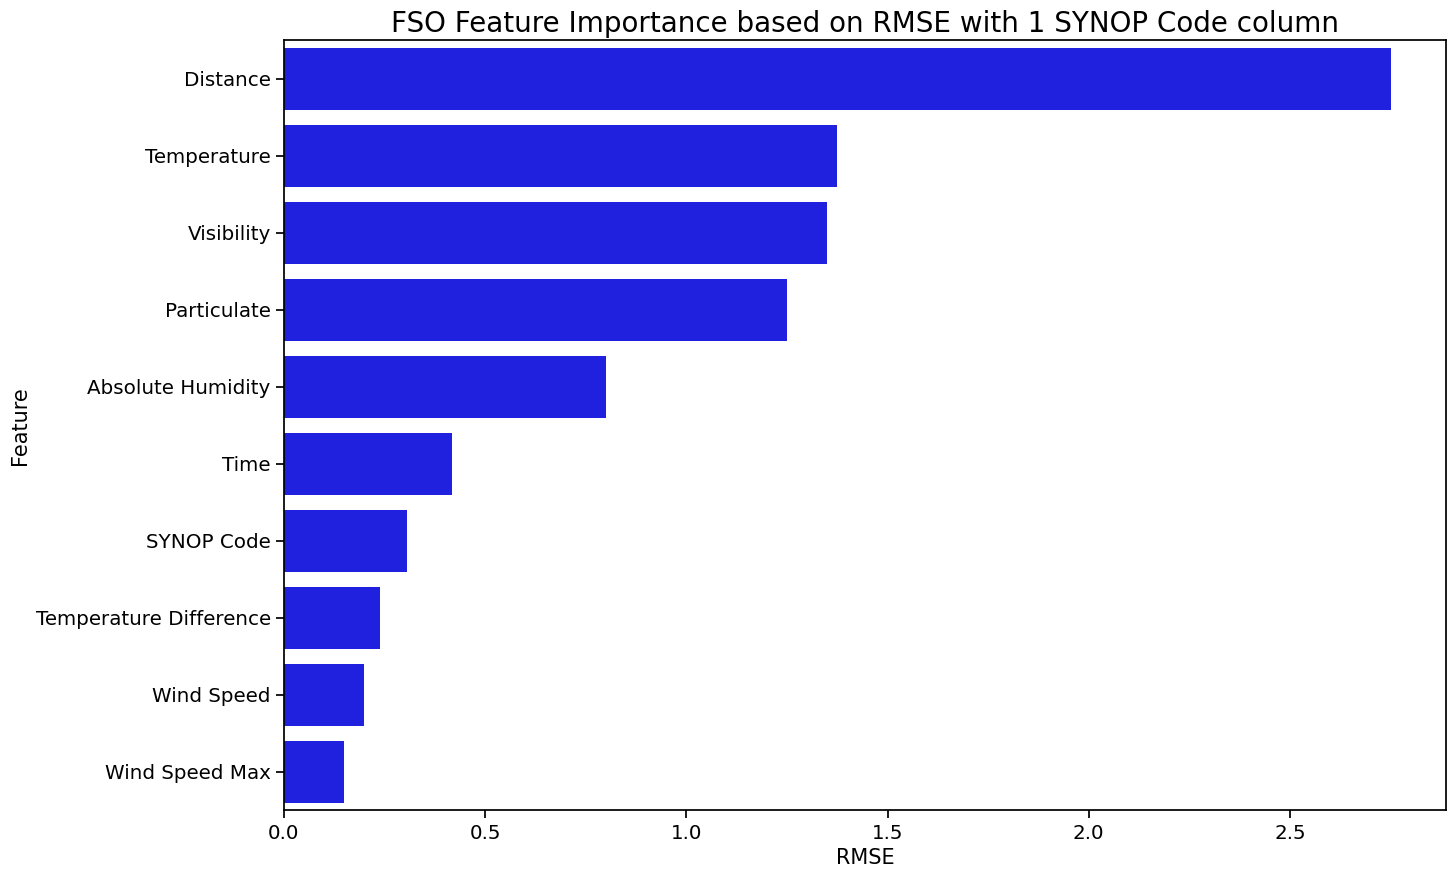

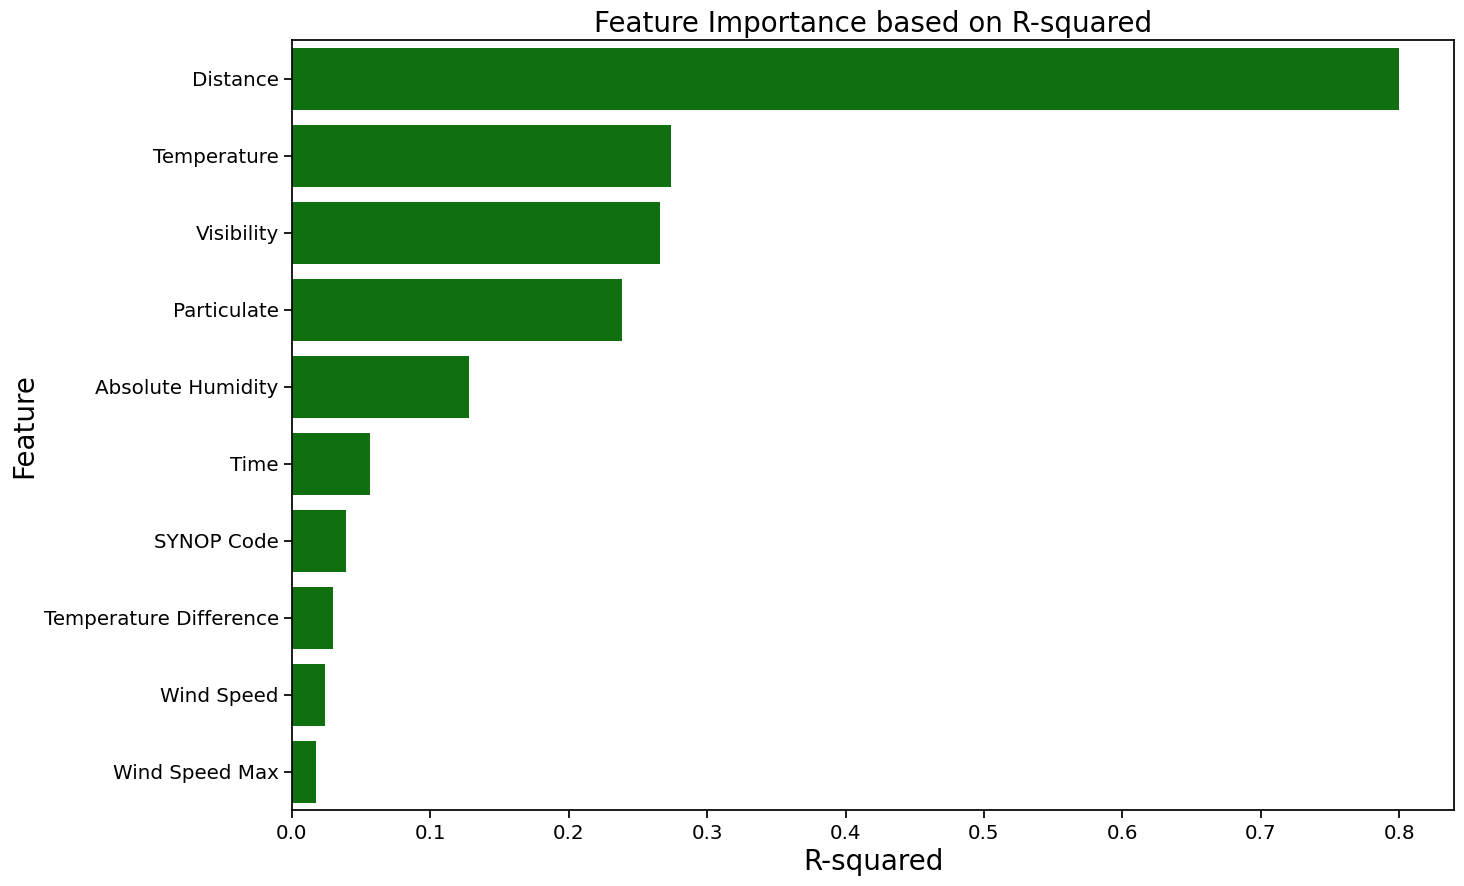

In [18]:
importance_df = importance_df.sort_values(by = 'RMSE_Difference', ascending=False)

sns.set_context("notebook", font_scale=1.3)
plt.figure(figsize=(15, 10))
sns.barplot(x='RMSE_Difference', y=importance_df.index, data=importance_df, color='b', label='RMSE Difference')
plt.xlabel('RMSE', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title('FSO Feature Importance based on RMSE with 1 SYNOP Code column', fontsize=20)
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(x='R2_Difference', y=importance_df.index, data=importance_df, color='g', label='R-squared Difference')
plt.xlabel('R-squared', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importance based on R-squared', fontsize=20)
plt.show()


### *plot two*

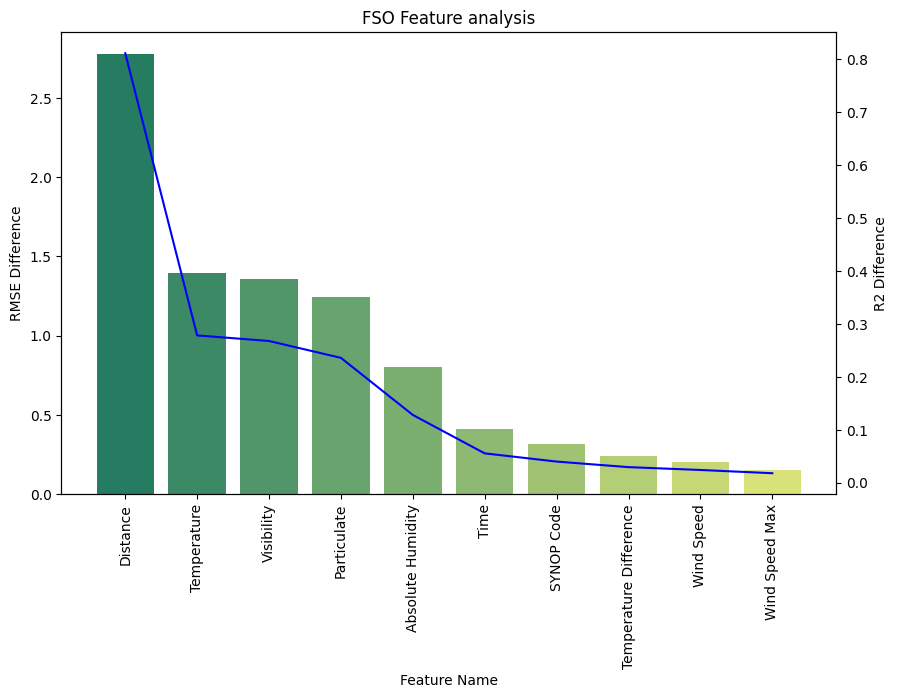

In [50]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10,6))

# Create the bar plot on the first y-axis
bar = sns.barplot(x=importance_df.index, y=importance_df['RMSE_Difference'], ax=ax1, palette='summer')

# Create a second y-axis
ax2 = ax1.twinx()

# Create the line plot on the second y-axis
sns.lineplot(x=importance_df.index, y=importance_df['R2_Difference'], ax=ax2, color='b')

# Set the labels
ax1.set_xlabel('Feature Name')
ax1.set_ylabel('RMSE Difference')
ax2.set_ylabel('R2 Difference')

# Rotate x-axis labels
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)

plt.title("FSO Feature analysis")
# Show the plot
plt.show()



## *Recursive Feature Elimination*

In [4]:
df = pd.read_csv("FSOData.csv")

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from math import sqrt


# Instantiate the Random Forest Regressor
clf = RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2)

# Specify the scoring method, in this case, the mean squared error
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the RFECV object
rfecv = RFECV(estimator=clf, step=1, cv=KFold(5), scoring=mse_scorer)

# Separate features and target variable
X = df.drop('FSO_Att', axis=1)
y = df['FSO_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Fit the RFECV to the training data
rfecv.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                      random_state=42),
      scoring=make_scorer(mean_squared_error, greater_is_better=False))

Optimal number of features: 9
Selected features: Index(['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time',
       'Wind Speed Max', 'Temperature', 'Temperature Difference',
       'Particulate', 'Distance'],
      dtype='object')


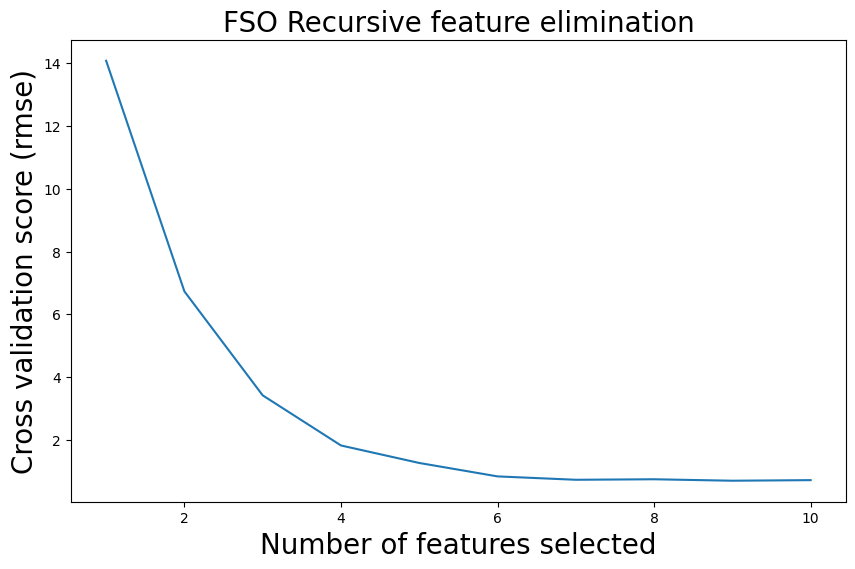

In [9]:
print(f"Optimal number of features: {rfecv.n_features_}")

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

print("Selected features:", selected_features)


plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), -rfecv.cv_results_['mean_test_score'])
plt.title("FSO Recursive feature elimination")
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.show()



10

In [26]:
# # Initial number of features
# feature_names = X_train.columns.tolist()
# initial_n_features = X_train.shape[1]

# for i in range(initial_n_features):
#     # Get a mask of selected features for this subset
#     feature_mask = rfecv.support_[:i+1]
#     # Get the names of the selected features
#     selected_features = np.array(feature_names)[feature_mask]
#     # Get the cross-validation score for this subset
#     subset_score = -rfecv.cv_results_['mean_test_score'][i]
#     print(f"Number of features: {i+1}")
#     print(f"Selected features: {selected_features}")
#     print(f"Cross-validation RMSE: {subset_score}\n")


# Initial number of features
initial_n_features = X_train.shape[1]

# Get feature names
feature_names = X_train.columns.tolist()

# Get the cross-validation scores
cv_scores = -rfecv.cv_results_['mean_test_score']

# Get the order of feature ranks. This will give us the order in which features were eliminated
feature_ranks = rfecv.ranking_

# Loop over each subset of features in the order they were eliminated
for i in range(initial_n_features, 0, -1):
    # Get a mask of selected features for this subset
    feature_mask = feature_ranks <= i
    # Get the names of the selected features
    selected_features = np.array(feature_names)[feature_mask]
    # Get the cross-validation score for this subset
    subset_score = cv_scores[i-1]  # Subtract 1 because cv_scores is 0-indexed
    print(f"Number of features: {sum(feature_mask)}")
    print(f"Selected features: {selected_features}")
    print(f"Cross-validation RMSE: {subset_score}\n")



Number of features: 10
Selected features: ['Absolute Humidity' 'Wind Speed' 'Visibility' 'Time' 'Wind Speed Max'
 'Temperature' 'Temperature Difference' 'Particulate' 'Distance'
 'SYNOP Code']
Cross-validation RMSE: 0.7227293234797293

Number of features: 10
Selected features: ['Absolute Humidity' 'Wind Speed' 'Visibility' 'Time' 'Wind Speed Max'
 'Temperature' 'Temperature Difference' 'Particulate' 'Distance'
 'SYNOP Code']
Cross-validation RMSE: 0.7041623127625875

Number of features: 10
Selected features: ['Absolute Humidity' 'Wind Speed' 'Visibility' 'Time' 'Wind Speed Max'
 'Temperature' 'Temperature Difference' 'Particulate' 'Distance'
 'SYNOP Code']
Cross-validation RMSE: 0.7504023039337532

Number of features: 10
Selected features: ['Absolute Humidity' 'Wind Speed' 'Visibility' 'Time' 'Wind Speed Max'
 'Temperature' 'Temperature Difference' 'Particulate' 'Distance'
 'SYNOP Code']
Cross-validation RMSE: 0.7343387156940887

Number of features: 10
Selected features: ['Absolute Hum

In [27]:
# Get the feature ranking
feature_ranking = rfecv.ranking_

# Print the feature ranking
for i, rank in enumerate(feature_ranking):
    print(f"Feature: {feature_names[i]}, Rank: {rank}")


Feature: Absolute Humidity, Rank: 1
Feature: Wind Speed, Rank: 1
Feature: Visibility, Rank: 1
Feature: Time, Rank: 1
Feature: Wind Speed Max, Rank: 1
Feature: Temperature, Rank: 1
Feature: Temperature Difference, Rank: 1
Feature: Particulate, Rank: 1
Feature: Distance, Rank: 1
Feature: SYNOP Code, Rank: 2


## FINAL MODEL WITHOUT 'Wind Speed Max' and 'Temperature Difference' 

In [12]:
# Selected features: Index(['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time',
#        'Wind Speed Max', 'Temperature', 'Temperature Difference',
#        'Particulate', 'Distance'],
#       dtype='object')
df = pd.read_csv("FSOData.csv")

In [14]:
# Define preprocessor
num_features = ['Absolute Humidity', 'Wind Speed', 'Visibility', 'Time', 
                'Temperature', 'Particulate', 'Distance', 'Temperature Difference'] 

cat_features = []

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators = 200, random_state = 42, 
                                                           max_depth = None, max_features = 'sqrt',
                                                           min_samples_leaf = 1, min_samples_split = 2))])

# Separate features and target variable
X = df.drop('FSO_Att', axis=1)
y = df['FSO_Att']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

clf.fit(X_train, y_train)

# Compute metrics for the new model
predictions = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("RMSE: ", rmse)
print("R-squared: ", r2)





RMSE:  0.7894980623097015
R-squared:  0.9583523292828158
